In [1]:
library(igraph)
library(tidygraph)
library(magrittr)
library(ggrepel)
library(tidyverse)
library(cowplot)
suppressMessages(library(network))
suppressMessages(library(sna))
library(ggnetwork)
library(scatterpie)
library(blur)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
)

theme_set(theme_cowplot() + theme_transparent)

results <- '../../results/'

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', 
                  col_names = FALSE, col_types = 'iciiii')
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))

methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS',
             'SConES GM','SConES GI','SigMod','All')
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff6f3c', 'SConES GI' = '#cb181d',
                    'SConES~GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'All' = 'gray50', 
                    'Consensus' = 'black', 'chi^2~+~Bonferroni' = '#000080')
labs <- c('all_snps' = 'All', 'chi2' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'scones_gi' = 'SConES GI', 
          'scones_gm' = 'SConES GM', 'scones_gs' = 'SConES GS', 'sigmod' = 'SigMod')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        ma

# Figure 1: Solutions overview

In [2]:
##########################
#     MANHATTAN PANEL    # 
##########################
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
gene_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha = .8, size = .75) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      axis.text = element_blank(),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(gene P-value)')) +
    theme_transparent

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
consensus_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% consensus), 
                                            aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                            color = '#2b2e4a', size = .75)

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% dmgwas), 
                                         aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                         color = '#2b2e4a', size = .75)

heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% heinz), 
                                        aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                        color = '#2b2e4a', size = .75)

hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
hotnet2_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% hotnet2), 
                                          aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                          color = '#2b2e4a', size = .75)

sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% sigmod), 
                                         aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                         color = '#2b2e4a', size = .75)

map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

snp_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size= .75) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      axis.text = element_blank(),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(SNP P-value)')) +
    theme_transparent

scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gi_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gi), 
                                           aes(x=BPcum, y=-log10(P)), 
                                           color = '#2b2e4a', size = .75)

manhattan_panel <- plot_grid(consensus_mh, dmgwas_mh, heinz_mh, 
                             hotnet2_mh, scones_gi_mh, sigmod_mh, 
                             labels = c('Consensus','dmGWAS','heinz','HotNet2','SConES GI','SigMod'),
                 nrow = 2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [3]:
##########################
#     TOPOLOGY PANEL     # 
##########################
plot_network <- function(net, selected_nodes) {
    
    graph <- activate(net, nodes) %>%
        filter(name %in% selected_nodes)
    class(graph) <- c('igraph','tbl_graph')
    
    ggnetwork(graph) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = '#323232') +
            geom_nodes(color = '#212121') +
            theme_blank() + theme_transparent + 
            theme(title = element_text(hjust = 1, face = 'bold'))
}

# dmgwas
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_plt <- plot_network(ppi, dmgwas)

# heinz
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_plt <- plot_network(ppi, heinz)

# hotnet2
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
hotnet2_plt <- plot_network(ppi, hotnet2)

# lean
lean_plt <- ggplot() + geom_blank() + theme_blank() + theme_transparent

# scones
load(paste0(results,'scones/gi_network.betweenness.RData'))
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gi_plt <- plot_network(gi_net, scones_gi)

# sigmod
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_plt <- plot_network(ppi, sigmod)

# add consensus network
set.seed(0)
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'),  col_types = 'cdidllllllli')$gene
consensus_plt <- plot_network(ppi, consensus)

topology_panel <- plot_grid(consensus_plt, dmgwas_plt, heinz_plt, hotnet2_plt, scones_gi_plt, sigmod_plt, 
                            labels = c('Consensus','dmGWAS','heinz','HotNet2','SConES GI','SigMod'))

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


In [4]:
##########################
#  HETEROGENEITY PANEL   # 
##########################
methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd')
all_genes <- unique(vegas$Gene)

dmgwas <- all_genes %in% (read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene)
heinz <- all_genes %in% (read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene)
hotnet2 <- all_genes %in% (read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene)
lean <- all_genes %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene)
sigmod <- all_genes %in% (read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene)
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gs <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gm <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gi <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, scones_gi, sigmod)
pearson_gene <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .)
pearson_gene[lower.tri(pearson_gene)] <- NA
pearson_gene_plt <- pearson_gene %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 2)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = 'red') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text = element_text(size = 10),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent

In [5]:
##########################
#     BIOMARKER PANEL    # 
##########################

get_precision_recall <- function(genes, selected, method, bonf) {
    
    genes %>%
        mutate(sign = P < bonf,
               selected = marker %in% selected) %>%
        summarize(precision = sum(selected & sign)/sum(selected),
                  recall = sum(selected & sign)/sum(sign)) %>%
        mutate(method = method)
    
}

# use only genes and SNPs that can be found in the PPIN & in GENESIS
genes_in_ppi <- names(V(ppi))
genes_in_genesis <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd') %>%
    .$Gene
snps_in_genesis <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd') %>%
    .$SNP

# GENESIS
##########################
genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    .$SNP
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

# BCAC
##########################
genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    filter(Gene %in% genes_in_ppi & Gene %in% genes_in_genesis) %>%
    rename(P = `Top-0.1-pvalue`,
           marker = Gene) %>%
    select(marker, P)

snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                 col_types = 'icdcddcddd') %>%
    filter(SNP %in% snps_in_genesis) %>%
    rename(marker = SNP) %>%
    select(marker, P)

bcac_comparison <- bind_rows(get_precision_recall(snps, genesis_sign, 'chi^2~+~Bonferroni', .05 / nrow(snps)),
                             get_precision_recall(genes, consensus, 'Consensus', .05 / nrow(genes)),
                             get_precision_recall(genes, heinz, 'heinz', .05 / nrow(genes)),
                             get_precision_recall(genes, sigmod, 'SigMod', .05 / nrow(genes)),
                             get_precision_recall(genes, dmgwas, 'dmGWAS', .05 / nrow(genes)),
                             get_precision_recall(genes, hotnet2, 'HotNet2', .05 / nrow(genes)),
                             get_precision_recall(snps, gi, 'SConES~GI', .05 / nrow(snps))) %>%
    ggplot(aes(recall, precision, color = method, label = method)) +
        geom_abline(slope = 1, color = 'gray80') +
        geom_point() +
        geom_text_repel(parse = T) +
        labs(x = 'Recall', y = 'Precision') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent, breaks = c(0, 0.5, 1)) +
        scale_color_manual(values = method_palette, labels = labs) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [6]:
legend <- get_legend(bcac_comparison + 
                     labs(color = 'Method') +
                     theme(legend.position = 'bottom',
                           legend.justification = 'center',
                           legend.text = element_text(size = 15),
                           legend.title = element_text(size = 15)))

f1 <- plot_grid(plot_grid(manhattan_panel,
                          plot_grid(pearson_gene_plt, bcac_comparison, nrow = 2, labels = c('B','C')),
                          ncol = 2, rel_widths = c(1,.45), labels = c('A','')),
                topology_panel,
                nrow = 2, labels = c('','D'))

Warning message:
“Removed 10 rows containing missing values (geom_text).”


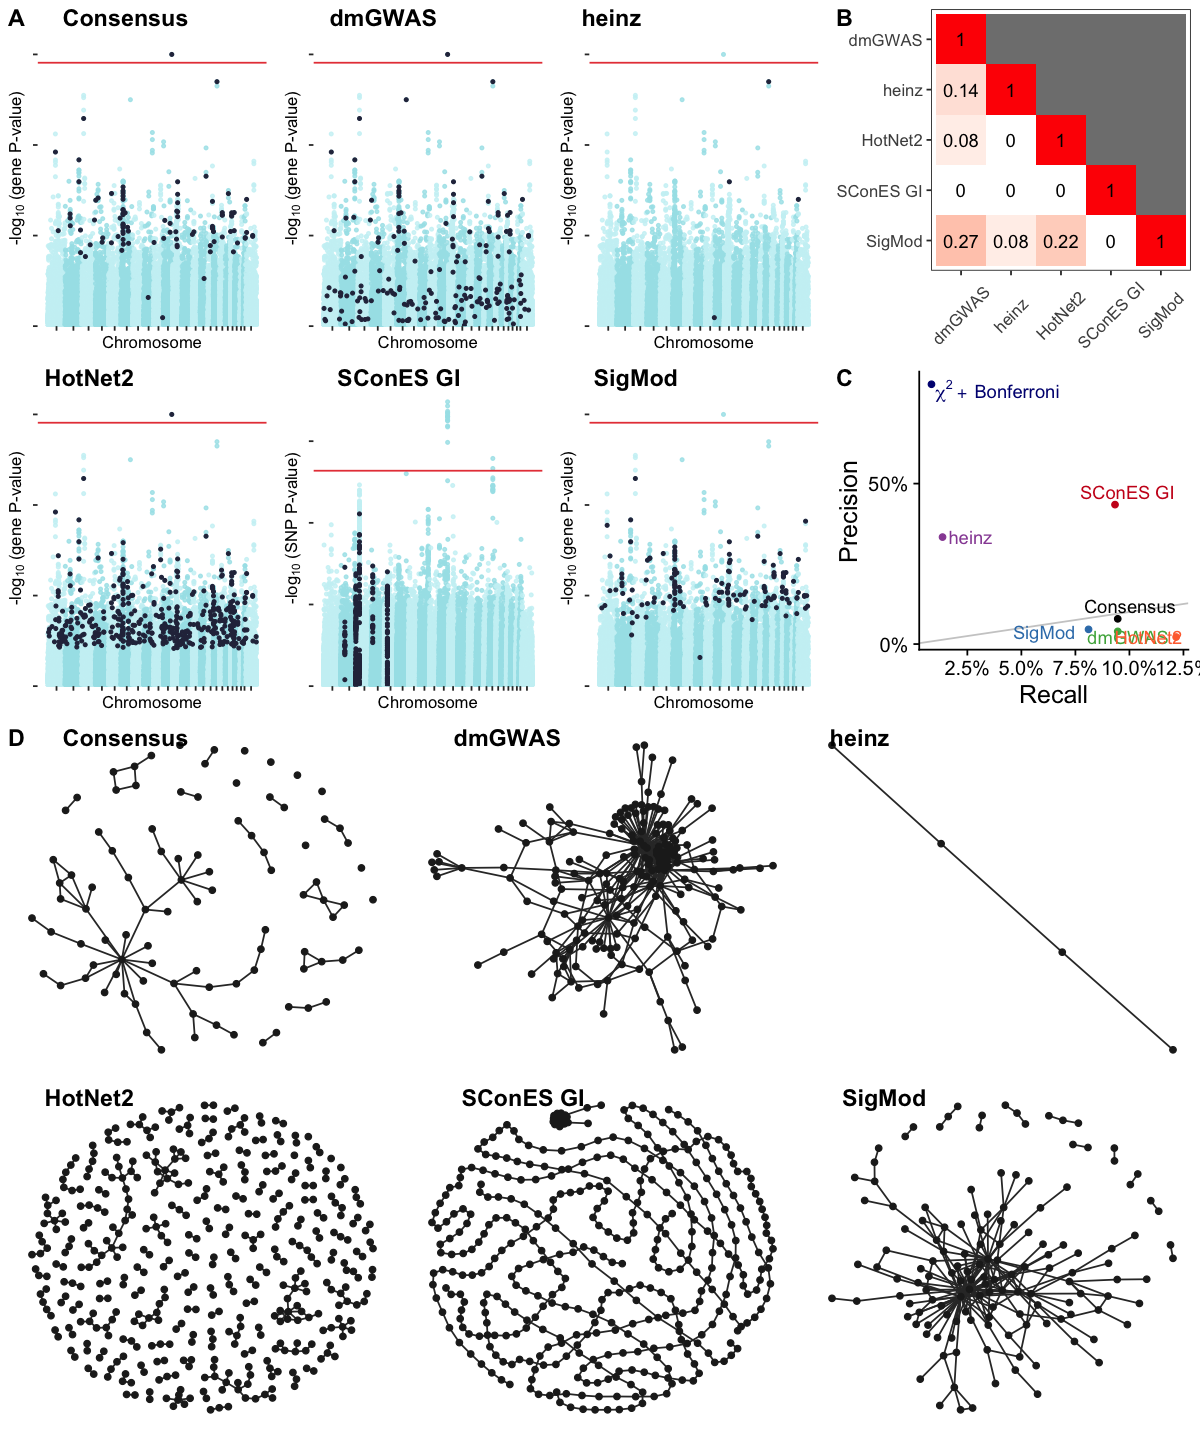

In [7]:
options(repr.plot.width=10, repr.plot.height=12)
f1
ggsave('figures/figure_1.pdf', f1, width=10, height=12, bg = "transparent")
ggsave('figures/figure_1.png', f1, width=10, height=12, bg = "transparent")

# Figure 2

In [8]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene

##########################
#         dmGWAS         # 
##########################
ppi_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas)
class(ppi_dmgwas) <- 'igraph'

dmgwas_flaw <- ggnetwork(ppi_dmgwas) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(aes(color = ifelse(p > 0.1, '> 0.1', '< 0.1'))) +
        labs(color = 'P-value') +
        theme_blank() +
        scale_color_manual(values = c('> 0.1' = 'gray20', '< 0.1' = 'red')) +
        theme(legend.position = 'bottom') +
        theme_transparent

##########################
#         SConES         # 
##########################
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli")
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli")
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli")
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')

scones_regions <- join_experiments(GS = gs, GM = gm, GI = gi) %>%
    left_join(snp2gene, by = "snp") %>%
    gather(key = "experiment", value = "selected", starts_with("selected")) %>%
    mutate(status = ifelse(!is.na(selected), ifelse(!is.na(gene), "Yes", "No"), 'Unselected'),
           status = factor(status, levels = c('Yes','No','Unselected')),
           experiment = gsub("selected_", "", experiment),
           experiment = factor(experiment, levels = unique(experiment))) %>%
    filter(status != 'Unselected') %>%
    ggplot(aes(x = experiment, y = as.character(pos), fill = status, colour = status)) +
        geom_tile() +
        labs(x = "SConES network", y = "Genomic coordinate", fill = "Gene mapped") +
        scale_fill_manual(values=c("Yes" = "#225ea8", 'No' = '#7fcdbb', 
                                   'Unselected' = '#FFFFF0')) +
        scale_color_manual(values=c("Yes" = "#225ea8", 'No' = '#7fcdbb', 
                                   'Unselected' = '#FFFFF0')) +
        theme_bw() +
        theme_transparent +
        theme(legend.position = 'bottom',
              panel.background = element_rect(fill = '#FFFFF0'),
              axis.text.x = element_text(size = 10),
              axis.text.y = element_blank(),
              axis.title = element_text(size = 11),
              axis.ticks.y = element_blank(),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(),
              strip.text = element_text(size = 11),
              legend.text = element_text(size = 10),
              legend.title = element_text(size = 11)) +
        guides(color = FALSE) +
        facet_grid(chr ~ ., scales = "free")

##########################
#       CENTRALITY       # 
##########################
ppi_selection <- ppi %>%
    mutate(degree = centrality_degree()) %>%
    inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd'), by = c('name' = 'Gene')) %>%
    mutate(p = Pvalue,
           what = ifelse(name %in% sigmod, 'SigMod', 'Unselected'),
           what = ifelse(name %in% dmgwas, 'dmGWAS', what),
           what = ifelse(name %in% hotnet2, 'HotNet2', what),
           what = ifelse(name %in% heinz, 'heinz', what),
           what = ifelse(name %in% consensus, 'Consensus', what))

centrality_plt <- ggplot() +
    geom_point(data = ppi_selection, aes(x = degree, y = -log10(p)), color = 'gray70', size = 2) +
    geom_point(data = filter(ppi_selection, what != 'Unselected'),
               aes(x = degree, y = -log10(p), fill = what), size = 2.5, shape = 21) +
    geom_label_repel(data = filter(ppi_selection, what != 'Unselected' & degree > 500),
                     aes(x = degree, y = -log10(p), label = name), size = 4) +
    guides(fill = guide_legend(ncol=2)) +
    labs(x = 'Centrality degree', y = bquote('-log' [10] ~'(BCAC P-value)'), fill = 'Selected by') +
    theme(legend.position = 'bottom', 
          text = element_text(size = 11),
          axis.text = element_text(size = 10)) +
    scale_fill_manual(values = method_palette)

f2 <- plot_grid(dmgwas_flaw, centrality_plt, labels = c('A', 'B'), nrow = 2) %>%
    plot_grid(scones_regions, labels = c('','C'), ncol = 2)

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


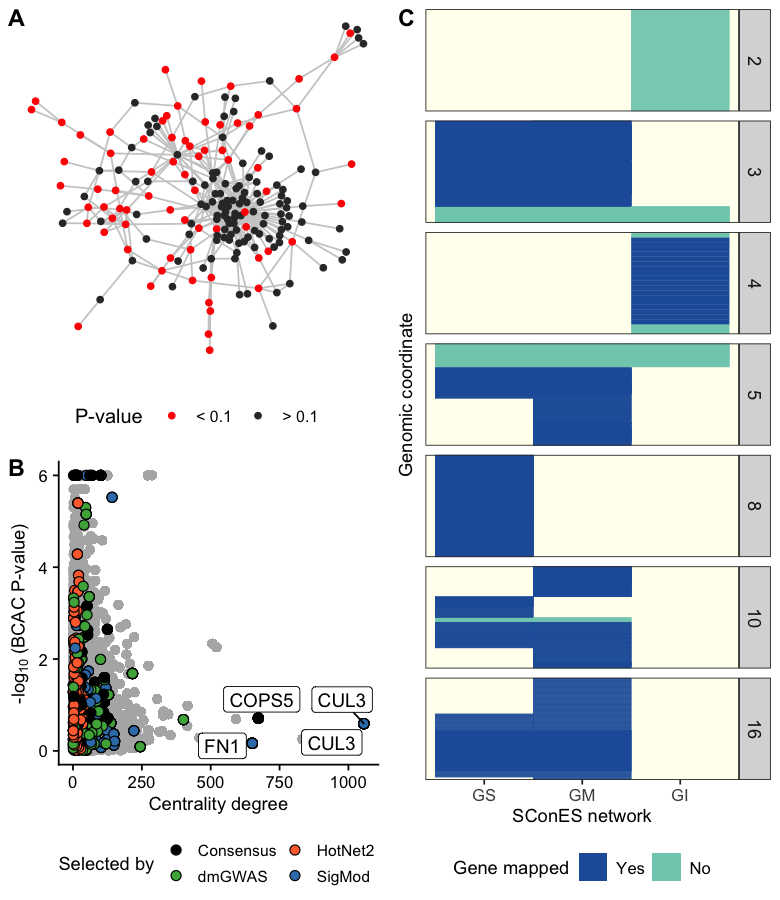

In [9]:
options(repr.plot.width=6.5, repr.plot.height=7.5)
f2
ggsave('figures/figure_2.pdf', f2, width=6.5, height=7.5,  bg = "transparent")

# Figure 3

In [10]:
cols_methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

set.seed(100)
consensus_nodes <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                            col_types = 'cdidllllllli')

consensus <- inner_join(ppi, consensus_nodes, by = c('name' = 'gene', 'p')) %>%
    mutate(degree = centrality_degree())
class(consensus) <- 'igraph'

consensus <- consensus %>%
    ggnetwork %>%
    mutate(name = as.character(name))

nodes <- mutate(consensus, dmGWAS = as.numeric(dmgwas),
                heinz = as.numeric(heinz),
                HotNet2 = as.numeric(hotnet2),
                `SConES GI` = as.numeric(scones_gi),
                SigMod = as.numeric(sigmod),
                radius = ifelse(disgenet | bcac | degree > 6, .025, .015)) %>%
    filter(xend == x & yend == y) %>% 
    select(x, y, name, degree, radius, p, disgenet, bcac, all_of(cols_methods)) %>%
    unique
edges <- filter(consensus, xend != x | yend != y)

f3 <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = '#393e46', size = 4) +
    geom_scatterpie(data = nodes, aes(x = x, y = y, r = radius), cols = cols_methods) +
    geom_label_repel(data = filter(nodes, disgenet | bcac | degree > 6), 
                     aes(x = x, y = y, label = name, color = (disgenet | bcac)), 
                     nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
                     hjust = 0.5, vjust = 0.5, size = 12) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme(legend.position = 'bottom',
          legend.text = element_text(size = 30, vjust = .2),
          legend.title = element_text(size = 40, vjust = 1)) +
    theme_transparent

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


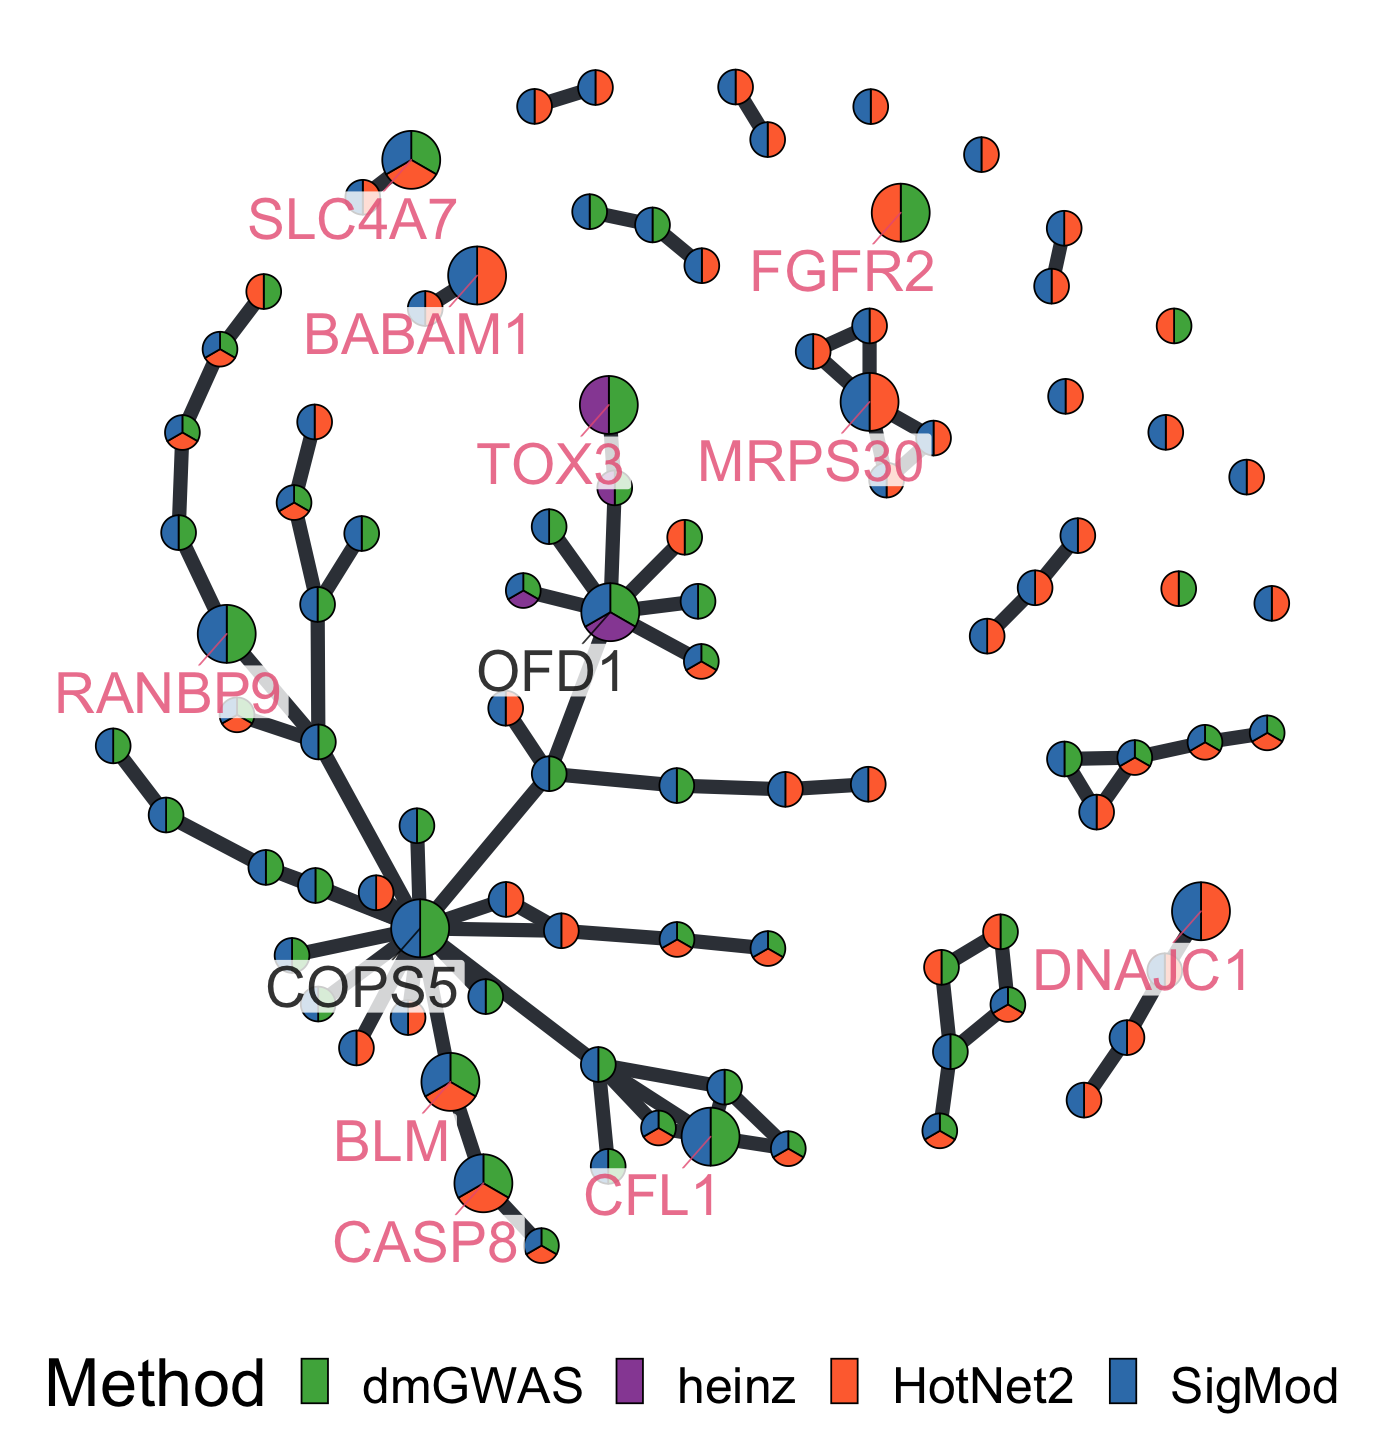

In [11]:
options(repr.plot.width=11.5, repr.plot.height=12)
f3
ggsave('figures/figure_3.pdf', f3, width=11.5, height=12, bg = "transparent")

# Figure 4: Benchmark

In [12]:
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES~GS',
             'SConES~GM','SConES~GI','SigMod','All','Consensus',
             'chi^2~+~Bonferroni')
labs <- c('all_snps' = 'All', 'chi^2~+~Bonferroni' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'SConES~GI' = 'SConES GI', 
          'SConES~GM' = 'SConES GM', 'SConES~GS' = 'SConES GS', 'sigmod' = 'SigMod')

parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}
                                     
scientific_10 <- function(x) {
    parse(text=gsub("1e", "10^", scales::scientific_format()(x)) %>% gsub("\\+", "", .))
}

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))

stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    filter(! method %in% c('lean','all_snps')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))

In [13]:
sel_act <- pred_ht %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set)) %>%
    ungroup %>%
    ggplot(aes(x = n_selected, y = n_active_set, 
               label = method, color = method)) +
        geom_abline(slope = 1, color = 'gray50', linetype="dashed") +
        geom_errorbar(aes(ymin = n_active_set - se_active, 
                          ymax = n_active_set + se_active), width = 400) +
        geom_errorbarh(aes(xmin = n_selected - se_selected, 
                           xmax = n_selected + se_selected), height = 40) +
        geom_point() +
        geom_text_repel(size = 3, parse = TRUE) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Number of selected SNPs', y = 'Active set size', 
             color = 'Method') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11)) + 
        guides(fill = "none")

naive_classifier <- max(table(fam$X6) / nrow(fam))

sens_spec <- pred_ht %>%
    filter(! method %in% c('SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity)) %>%
    ggplot(aes(x = sensitivity, y = specificity, label = method, color = method)) +
        geom_hline(yintercept = naive_classifier, color = 'gray50', linetype="dashed") +
        geom_vline(xintercept = naive_classifier, color = 'gray50', linetype="dashed") +
        geom_errorbar(aes(ymin = specificity - se_specificity, 
                          ymax = specificity + se_specificity), width = .0025) +
        geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                           xmin = sensitivity - se_sensitivity), height = .0025) +
        geom_point() +
        geom_text_repel(parse = T, size = 3, segment.size = .2, nudge_x = -.03, nudge_y = .02) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11)) + 
        guides(fill = "none")

corr <- filter(stab_ht, ! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    ggplot(aes(x = method, y = pearson, fill = method)) +
        geom_boxplot(color = 'gray20') +
        scale_x_discrete(labels = labs) +
        coord_flip() +
        labs(y = 'Pearson\'s correlation') +
        scale_fill_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11))

time <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES~GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES~GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(method == 'SConES GI', alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene')) %>%
    filter(! method %in% c('All', 'Consensus', 'chi^2~+~Bonferroni', 'SConES~GS', 'SConES~GM', 'vegas')) %>%
    mutate(method = factor(method, levels = rev(methods))) %>%
    select(method, alg_time_s, tot_time_s, type) %>%
    gather(time_type, time_s, -type, -method) %>%
    filter(!(method == 'SConES~GI' & time_type == 'alg_time_s')) %>%
    ggplot(aes(x = method, y = time_s, fill = method, shape = time_type, size = time_type)) +
        geom_point(color = 'black') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        scale_x_discrete(label=labs) +
        scale_y_log10(label=scientific_10) +
        labs(y = 'Time (s)') +
        theme(legend.position = 'none',
              axis.title.y = element_blank(),
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        scale_shape_manual(values=c('alg_time_s' = 25, 'tot_time_s' = 21)) +
        scale_size_manual(values=c('alg_time_s' = 1.5, 'tot_time_s' = 3)) +
        coord_flip() +
        facet_grid(type ~ ., scales = 'free', space = 'free')

f4 <- plot_grid(sel_act, sens_spec, corr, time, nrow = 2, labels = c('A','B','C','D'))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“1 parsing failure.
row  col   expected actual                                file
 89 exit an integer      - '../../results/benchmark/trace.txt'
”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [128, 133].”


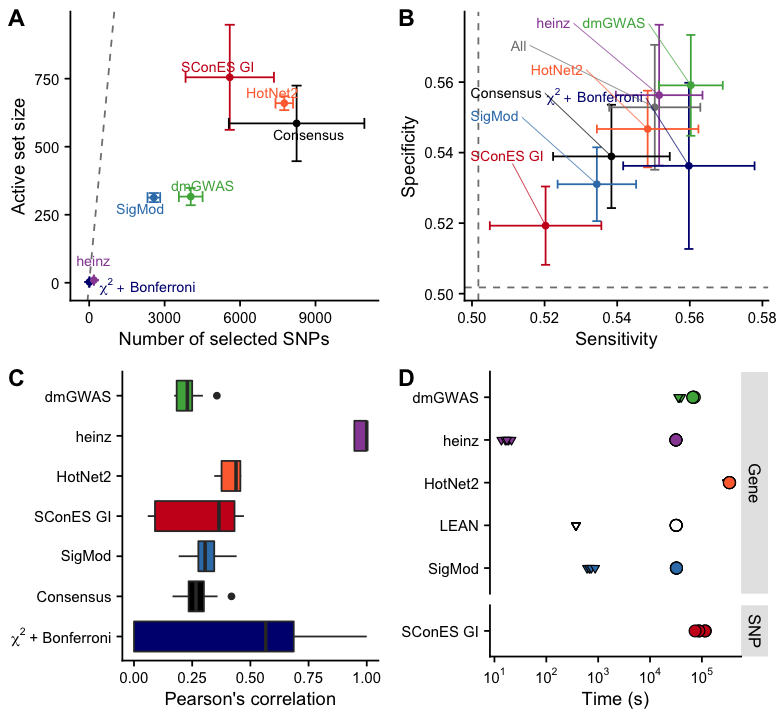

In [14]:
options(repr.plot.width=6.5, repr.plot.height=6)
f4
ggsave('figures/figure_4.pdf', f4, width=6.5, height=6, bg = "transparent")

# Figure 5: stability consensus

In [15]:
genes <- list.files(paste0(results, 'benchmark/all_outputs')) %>%
    lapply(function(x) {
        read_tsv(paste0(results, 'benchmark/all_outputs/', x), col_names = F, col_types = 'c') %>%
            rename(gene = X1) %>%
            filter(gene != 'gene') %>%
            unique %>%
            mutate(method = gsub('_[0-9]*.txt', '', x = x),
                   id = gsub('.*_', '', x = x),
                   id = gsub('.txt', '', x = id))
    }) %>%
    bind_rows %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method))

genes_wide <- group_by(genes, gene, method) %>% 
    summarize(n = n()) %>% spread(key = method, value = n) %>%
    mutate(Consensus = ifelse(is.na(Consensus), 0, Consensus),
           dmGWAS = ifelse(is.na(dmGWAS), 0, dmGWAS),
           heinz = ifelse(is.na(heinz), 0, heinz),
           HotNet2 = ifelse(is.na(HotNet2), 0, HotNet2),
           `SConES GI` = ifelse(is.na(`SConES GI`), 0, `SConES GI`),
           SigMod = ifelse(is.na(SigMod), 0, SigMod),
           n = rowSums(cbind(dmGWAS, heinz, HotNet2, `SConES GI`, SigMod)))

# Read known genes
bcac_genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                       col_types = 'iciddddddcd') %>%
    filter(`Top-0.1-pvalue` < 0.05 / n()) %>%
    .$Gene

known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

consensus_methods <- genes %>%
    filter(method != 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    filter(n > 6) %>%
    arrange(-n) %>%
    .$gene

class(ppi) <- c('igraph','tbl_graph')
net <- ppi %>%
    filter(name %in% consensus_methods) %>%
    inner_join(genes_wide, by = c('name' = 'gene')) %>%
    mutate(known = name %in% bcac_genes | name %in% known_brca_genes,
           degree = centrality_degree()) %>%
    ggnetwork

f5 <- ggplot(net, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(size = 4, color = '#393e46') +
        geom_scatterpie(data = filter(net, x == xend & y == yend), 
                        aes(x = x, y = y, r = n/400), cols = cols_methods) +
        geom_label_repel(data = filter(net, x == xend & y == yend & (known | degree > 4)), 
                         aes(x = x, y = y, label = name, color = known), 
                         nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
                         hjust = 0.5, vjust = 0.5, size = 12) + 
        labs(fill = 'Method') +
        scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
        scale_fill_manual(values = method_palette) +
        guides(color = FALSE,
               fill = guide_legend(nrow = 2, title.vjust = .5)) +
        theme_blank() +
        theme(legend.position = 'bottom',
              legend.text = element_text(size = 30, vjust = .2),
              legend.title = element_text(size = 40, vjust = 1)) +
        theme_transparent

`summarise()` regrouping output by 'gene' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



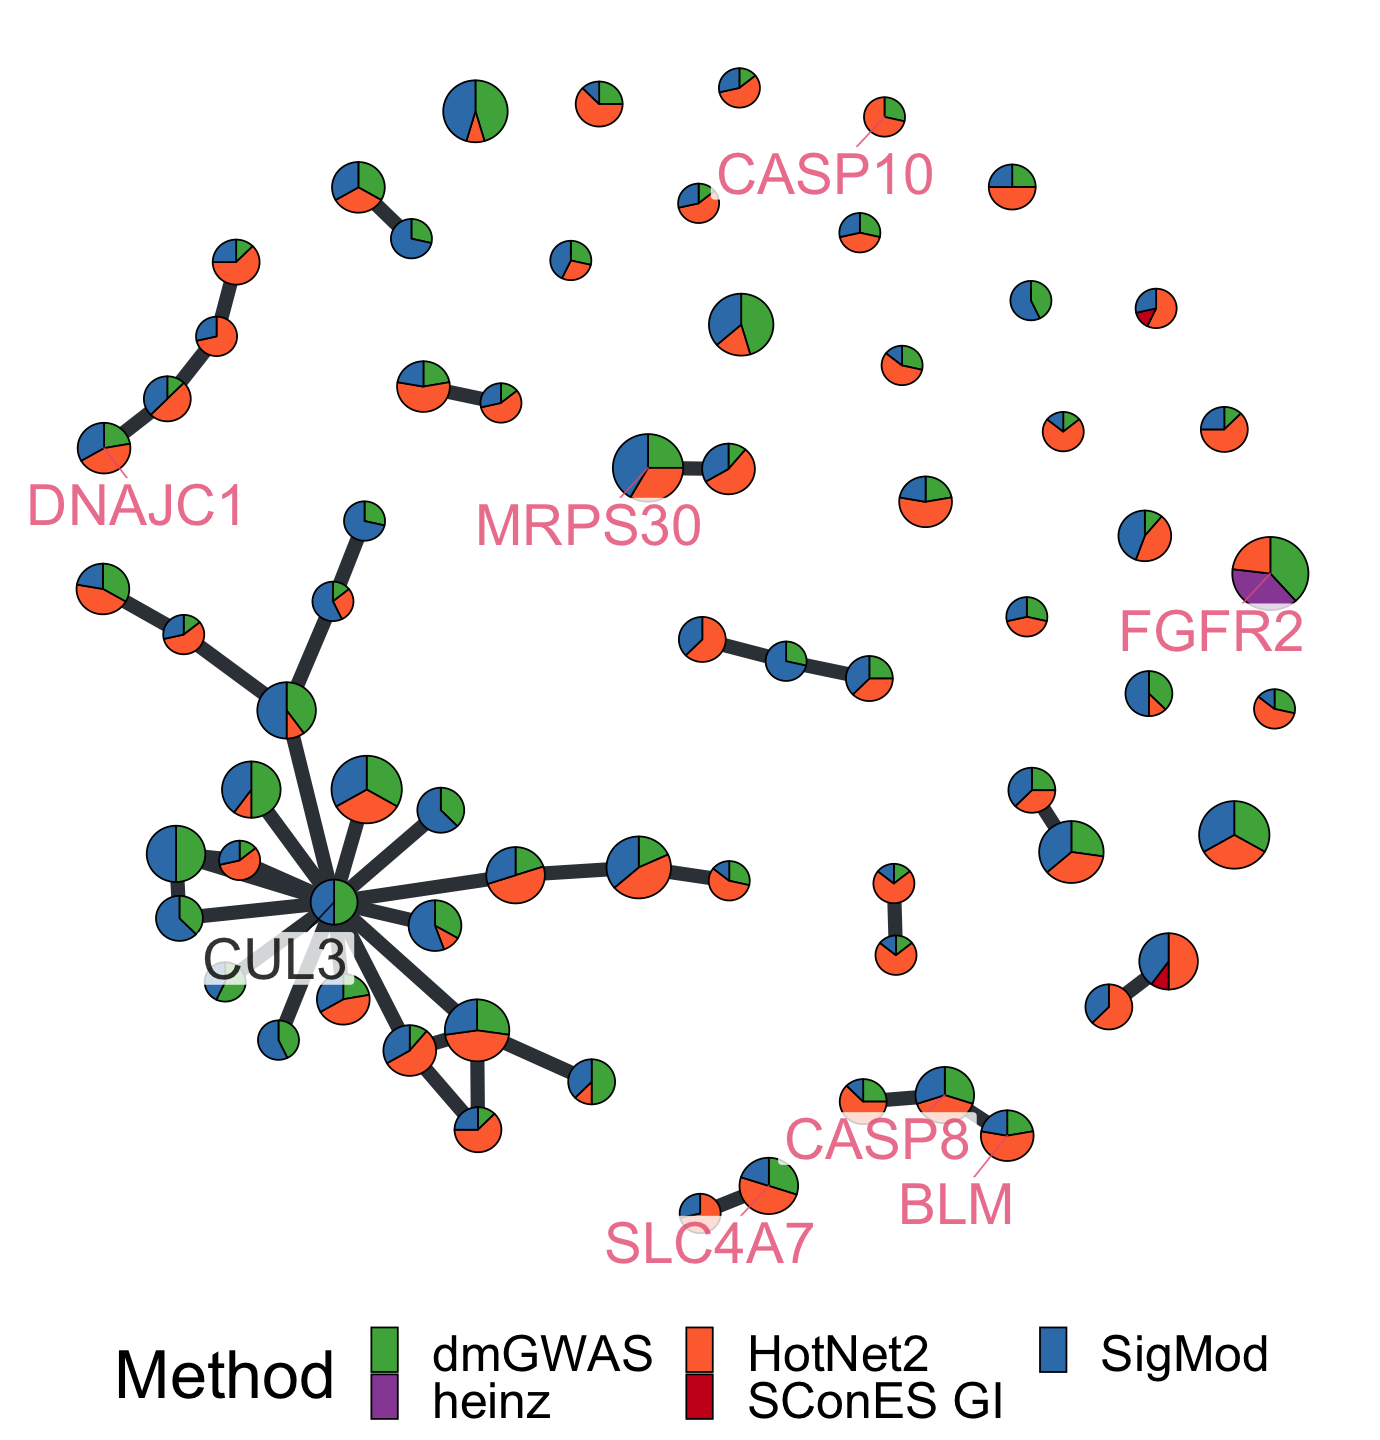

In [16]:
options(repr.plot.width=11.5, repr.plot.height=12)
f5
ggsave('figures/figure_5.pdf', f5, width=11.5, height=12, bg = "transparent")